In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.preprocessing import RobustScaler
from umap import UMAP
from tsfresh import extract_features
from tsfresh.feature_extraction import MinimalFCParameters, EfficientFCParameters
from sklearn.metrics import silhouette_score
import glob
from itertools import groupby
from operator import itemgetter
from scipy.stats import mannwhitneyu

2025-02-13 11:03:12.749810: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-13 11:03:12.760627: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-13 11:03:12.763911: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-13 11:03:12.772919: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-13 11:03:13.417374: W tensorflow/compiler/tf2

In [2]:

def get_index(data,th):
    idx = []
    for i in range(len(data)):
        if (data[i]>=th):
            idx.append(i)
    
    index = []
    for k, g in groupby(enumerate(idx),lambda ix : ix[0] - ix[1]):
        index.append((list((map(itemgetter(1), g)))))
    return index

def scale_data(data):
    min_val =  np.min(data)
    max_val = np.max(data)
    return (((data - min_val) / (max_val - min_val)) * 10)

def load_and_combine(file_pattern):
    """Load and combine trajectory files with proper ID handling."""
    files = sorted(glob.glob(file_pattern))
    dfs = []
    for i, f in enumerate(files):
        df = pd.read_hdf(f)
        df = df.iloc[:-1]  # Drop last row
        df['trajectory_id'] = f'traj_{i}'
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

def load_and_combine_cfd(file_pattern):
    """Load and combine trajectory files with proper ID handling."""
    files = sorted(glob.glob(file_pattern))
    dfs = []
    for i, f in enumerate(files):
        df = pd.read_hdf(f)
        df = df.iloc[:-1]  # Drop last row
        df['trajectory_id'] = f'traj_{i}'
        dfs.append(df)
    combined_df=pd.concat(dfs, ignore_index=True)
    combined_df['odor']=scale_data(combined_df.odor)
    return combined_df

def calculate_metrics(X_umap, labels):
    """Calculate silhouette score and normalized centroid distance."""
    # Convert string labels to numeric for silhouette score
    unique_labels = np.unique(labels)
    label_map = {label: i for i, label in enumerate(unique_labels)}
    numeric_labels = np.array([label_map[label] for label in labels])
    
    # Calculate silhouette score
    silhouette = silhouette_score(X_umap, numeric_labels)
    
    # Calculate centroids
    centroids = []
    for label in range(len(unique_labels)):
        mask = numeric_labels == label
        centroid = np.mean(X_umap[mask], axis=0)
        centroids.append(centroid)
    centroids = np.array(centroids)
    
    # Calculate distance between centroids
    centroid_dist = cdist(centroids, centroids)[0, 1]
    
    # Calculate average spread within clusters
    spreads = []
    for label, centroid in enumerate(centroids):
        mask = numeric_labels == label
        points = X_umap[mask]
        spread = np.mean(cdist(points, centroid.reshape(1, -1)))
        spreads.append(spread)
    
    avg_spread = np.mean(spreads)
    normalized_dist = centroid_dist / (avg_spread + 1e-10)
    
    return silhouette, normalized_dist

def process_odor_signal(df, threshold=6.5):
    """Process odor signal to keep only whiff values."""
    # Create a copy of the odor column
    df = df.copy()    
    # Process odor by trajectory
    for traj_id, traj_df in df.groupby('trajectory_id'):
        odor_series = traj_df['odor'].values
        
        # Get whiff indices
        whiff_idx = get_index(odor_series, threshold)
        
        # Create mask of zeros
        processed_odor = np.zeros_like(odor_series)
        
        # Set whiff values
        for idx_group in whiff_idx:
            processed_odor[idx_group] = odor_series[idx_group]
        
        # Update the dataframe
        df.loc[traj_df.index, 'odor'] = processed_odor
    return df



In [3]:
# settings = MinimalFCParameters()
# print("Minimal feature calculations:", settings)

Minimal feature calculations: {'sum_values': None, 'median': None, 'mean': None, 'length': None, 'standard_deviation': None, 'variance': None, 'root_mean_square': None, 'maximum': None, 'absolute_maximum': None, 'minimum': None}


Feature Extraction: 100%|██████████| 77/77 [00:00<00:00, 91.37it/s] 
/home/gorilla/An/arunavanag/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



Cluster Quality Metrics:
Silhouette Score: 0.015
Normalized Centroid Distance: 0.041


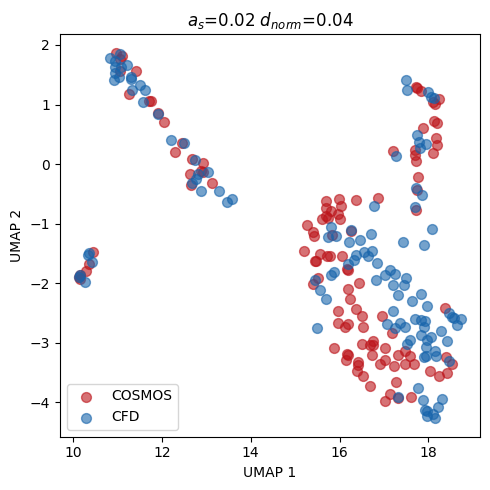

In [6]:
class TrajectoryComparison:
    def __init__(self, cosmos_df, cfd_df):
        self.cosmos_df = cosmos_df
        self.cfd_df = cfd_df
        self.feature_scaler = None
        self.umap_reducer = None
        
    def normalize_units(self):
        """Ensure consistent units between datasets"""
        # Scale spatial coordinates to same range
        for df in [self.cosmos_df, self.cfd_df]:
            # Normalize spatial components
            spatial_cols = ['x', 'y', 'vx', 'vy', 'crosswind_dist', 'upwind_dist']
            for col in spatial_cols:
                if col in df.columns:
                    df[col] = df[col] / df[col].abs().max()
            
            # Normalize time steps
            df['time'] = (df['time'] - df['time'].min()) / (df['time'].max() - df['time'].min())
            
            # Normalize angles to [-1, 1]
            angle_cols = ['heading_angle']
            for col in angle_cols:
                if col in df.columns:
                    df[col] = np.unwrap(df[col]) % (2 * np.pi)
                    df[col] = df[col] / np.pi - 1
            
            # Normalize other quantities
            if 'speed' in df.columns:
                df['speed'] = df['speed'] / df['speed'].max()
            if 'acceleration' in df.columns:
                df['acceleration'] = df['acceleration'] / df['acceleration'].abs().max()
            if 'angular_velocity' in df.columns:
                df['angular_velocity'] = df['angular_velocity'] / df['angular_velocity'].abs().max()
            if 'path_curvature' in df.columns:
                df['path_curvature'] = df['path_curvature'] / df['path_curvature'].abs().max()
    
    def add_derived_features(self, df):
        """Add carefully normalized derived features"""
        # Simple path efficiency (ratio of displacement to path length)
        df['cumulative_dx'] = df.groupby('trajectory_id')['vx'].cumsum()
        df['cumulative_dy'] = df.groupby('trajectory_id')['vy'].cumsum()
        df['path_length'] = np.sqrt(df['cumulative_dx']**2 + df['cumulative_dy']**2)
        df['path_length'] = df['path_length'] / df['path_length'].max()
        
        # Turn rate (normalized)
        df['turn_rate'] = np.gradient(df['heading_angle'], df['time'])
        df['turn_rate'] = df['turn_rate'] / df['turn_rate'].abs().max()
        
        return df
    
    def extract_features(self):
        """Extract features using minimal tsfresh parameters"""
        # Define basic columns to extract features from
        base_cols = [
            "vx", "vy", "speed", "acceleration",
            "heading_angle", "angular_velocity",
            "crosswind_dist", "upwind_dist",
            "path_curvature", "turn_rate",
            "path_length"
        ]
        
        # Use only columns that exist in both datasets
        available_cols = []
        for col in base_cols:
            if col in self.cosmos_df.columns and col in self.cfd_df.columns:
                available_cols.append(col)
        
        # Use minimal feature set from tsfresh
        settings = MinimalFCParameters()
        # settings = EfficientFCParameters()
        
        # Extract features for both datasets
        cosmos_features = extract_features(
            self.cosmos_df[['trajectory_id', 'time'] + available_cols],
            column_id='trajectory_id',
            column_sort='time',
            default_fc_parameters=settings
        )
        
        cfd_features = extract_features(
            self.cfd_df[['trajectory_id', 'time'] + available_cols],
            column_id='trajectory_id',
            column_sort='time',
            default_fc_parameters=settings
        )
        
        # Ensure both feature sets have the same columns
        common_cols = cosmos_features.columns.intersection(cfd_features.columns)
        cosmos_features = cosmos_features[common_cols]
        cfd_features = cfd_features[common_cols]
        
        # Balance datasets if needed
        min_size = min(len(cosmos_features), len(cfd_features))
        if len(cosmos_features) > min_size:
            cosmos_features = cosmos_features.sample(n=min_size, random_state=42)
        if len(cfd_features) > min_size:
            cfd_features = cfd_features.sample(n=min_size, random_state=42)
        
        return cosmos_features, cfd_features
    
    def fit_transform(self, n_neighbors=15, min_dist=0.1, metric='euclidean'):
        """Fit and transform data with careful preprocessing"""
        # Normalize units
        self.normalize_units()
        
        # Add derived features
        self.cosmos_df = self.add_derived_features(self.cosmos_df)
        self.cfd_df = self.add_derived_features(self.cfd_df)
        
        # Extract features
        cosmos_features, cfd_features = self.extract_features()
        
        # print("Number of features:", len(cosmos_features.columns))
        # print("\nFeature names:")
        # for col in cosmos_features.columns:
        #     print(col)


        
        # Combine features
        X = pd.concat([cosmos_features, cfd_features])
        y = np.concatenate([
            np.zeros(len(cosmos_features)),
            np.ones(len(cfd_features))
        ])
        
        # Scale features
        self.feature_scaler = RobustScaler()
        X_scaled = self.feature_scaler.fit_transform(X)
        
        # Fit UMAP
        self.umap_reducer = UMAP(
            n_neighbors=n_neighbors,
            min_dist=min_dist,
            metric=metric,
            random_state=42
        )
        X_umap = self.umap_reducer.fit_transform(X_scaled)
        
        return X_umap, y
        
    def analyze_temporal_correlation(self):
        """Analyze temporal correlation between odor encounters and movement patterns."""
        def compute_windowed_correlation(odor, velocity, window_size=100):
            T = len(odor)
            correlation = np.zeros(T)
            
            # Standardize signals
            odor_std = (odor - np.mean(odor)) / np.std(odor)
            vel_std = (velocity - np.mean(velocity)) / np.std(velocity)
            
            # Compute windowed correlation
            for t in range(T - window_size):
                odor_window = odor_std[t:t+window_size]
                vel_window = vel_std[t:t+window_size]
                correlation[t] = np.sum(odor_window * vel_window) / window_size
                
            return correlation

        # Compute correlations for both simulators
        cosmos_correlations = []
        cfd_correlations = []
        
        # Process COSMOS trajectories
        for traj_id in self.cosmos_df['trajectory_id'].unique():
            traj = self.cosmos_df[self.cosmos_df['trajectory_id'] == traj_id]
            odor = traj['odor'].values
            velocity = np.sqrt(traj['vx']**2 + traj['vy']**2).values
            corr = compute_windowed_correlation(odor, velocity)
            cosmos_correlations.append(np.mean(corr))
        
        # Process CFD trajectories
        for traj_id in self.cfd_df['trajectory_id'].unique():
            traj = self.cfd_df[self.cfd_df['trajectory_id'] == traj_id]
            odor = traj['odor'].values
            velocity = np.sqrt(traj['vx']**2 + traj['vy']**2).values
            corr = compute_windowed_correlation(odor, velocity)
            cfd_correlations.append(np.mean(corr))
        
        # Statistical test
        statistic, pvalue = mannwhitneyu(cosmos_correlations, cfd_correlations)
        
        return {
            'cosmos_correlations': np.array(cosmos_correlations),
            'cfd_correlations': np.array(cfd_correlations),
            'p_value': pvalue
        }
    
    def plot_comparison(self, X_umap, labels, silhouette, norm_dist):
        """Plot comparison with enhanced visualization and axis labels."""
        f, ax = plt.subplots(figsize=(5, 5))
        
        # Plot points
        for i, label in enumerate(['COSMOS', 'CFD']):
            mask = labels == i
            ax.scatter(
                X_umap[mask, 0],
                X_umap[mask, 1],
                label=label,
                alpha=0.6,
                s=50,
                c=['#bc141a', '#1764ab'][i]
            )
        
        # Calculate variance ratios directly from UMAP coordinates
        # var_ratio = np.var(X_umap, axis=0)
        # var_ratio = (var_ratio / np.sum(var_ratio)) * 100
        
        # # Add labels with variance percentages
        # ax.set_xlabel(f'UMAP 1 ({var_ratio[0]:.1f}% var)')
        # ax.set_ylabel(f'UMAP 2 ({var_ratio[1]:.1f}% var)')
        
        ax.set_xlabel('UMAP 1')
        ax.set_ylabel('UMAP 2')

        ax.set_title(f'$a_s$={silhouette:.2f} $d_{{norm}}$={norm_dist:.2f}')
        ax.legend()
        f.tight_layout()
        
        return f

if __name__ == "__main__":
    path = "/home/gorilla/An/data/simulator/plot/tracking_figure/feb4/"
    osdf_combined = load_and_combine(str(path)+"os*.h5")
    cfd_df_combined = load_and_combine_cfd(str(path)+"cfd*.h5")
    
    # Create comparison object
    comparator = TrajectoryComparison(osdf_combined, cfd_df_combined)
    X_umap, labels = comparator.fit_transform(
        n_neighbors=50,  # 
        min_dist=0.1,    
        metric='euclidean'  
    )
    
    silhouette, norm_dist = calculate_metrics(X_umap, labels)
    comparator.plot_comparison(X_umap, labels, silhouette, norm_dist)

    print("\nCluster Quality Metrics:")
    print(f"Silhouette Score: {silhouette:.3f}")
    print(f"Normalized Centroid Distance: {norm_dist:.3f}")
    
# Analyze temporal correlations
    # correlation_results = comparator.analyze_temporal_correlation()

    # print(f"Correlation Analysis p-value: {correlation_results['p_value']:.3f}")

    # # Optional: Plot correlation distributions
    # plt.figure(figsize=(6, 4))
    # plt.boxplot([correlation_results['cosmos_correlations'], 
    #             correlation_results['cfd_correlations']],
    #             labels=['COSMOS', 'CFD'])
    # plt.ylabel('Odor-Motion Correlation')
    # plt.title('Temporal Correlation Comparison')
    # plt.show()

In [36]:
# # # Save UMAP data
# np.save("X_umap.npy", X_umap)
# np.save("labels.npy", labels)
# from scipy.stats import gaussian_kde
# import seaborn


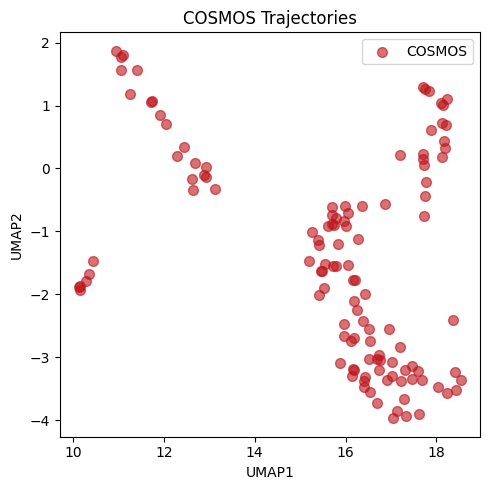

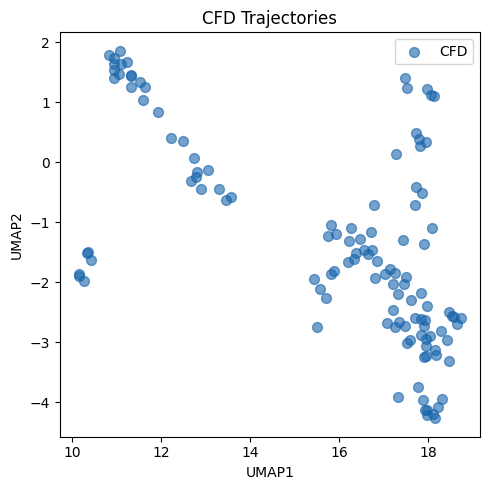

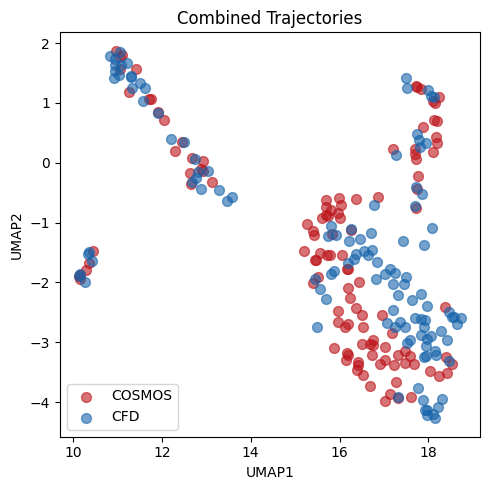

In [7]:
colors = {'COSMOS': '#bc141a', 'CFD': '#1764ab'}

# Calculate variance ratios for axis labels
# 1. COSMOS only plot
fig1, ax1 = plt.subplots(figsize=(5, 5))
mask_cosmos = labels == 0
ax1.scatter(X_umap[mask_cosmos, 0], X_umap[mask_cosmos, 1], 
           c=colors['COSMOS'], alpha=0.6, s=50, label='COSMOS')
ax1.set_xlabel('UMAP1')
ax1.set_ylabel('UMAP2')
ax1.set_title('COSMOS Trajectories')
ax1.legend()
fig1.tight_layout()

# 2. CFD only plot
fig2, ax2 = plt.subplots(figsize=(5, 5))
mask_cfd = labels == 1
ax2.scatter(X_umap[mask_cfd, 0], X_umap[mask_cfd, 1],
            c=colors['CFD'], alpha=0.6, s=50, label='CFD')
ax2.set_xlabel('UMAP1')
ax2.set_ylabel('UMAP2')
ax2.set_title('CFD Trajectories')
ax2.legend()
fig2.tight_layout()

# 3. Combined scatter plot
fig3, ax3 = plt.subplots(figsize=(5, 5))
ax3.scatter(X_umap[mask_cosmos, 0], X_umap[mask_cosmos, 1],
            c=colors['COSMOS'], alpha=0.6, s=50, label='COSMOS')
ax3.scatter(X_umap[mask_cfd, 0], X_umap[mask_cfd, 1],
            c=colors['CFD'], alpha=0.6, s=50, label='CFD')
ax3.set_xlabel('UMAP1')
ax3.set_ylabel('UMAP2')
ax3.set_title('Combined Trajectories')
ax3.legend()
fig3.tight_layout()


Parameters with odor

Feature Extraction: 100%|██████████| 79/79 [00:01<00:00, 71.88it/s] 
/home/gorilla/An/arunavanag/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



Cluster Quality Metrics:
Silhouette Score: 0.090
Normalized Centroid Distance: 0.471


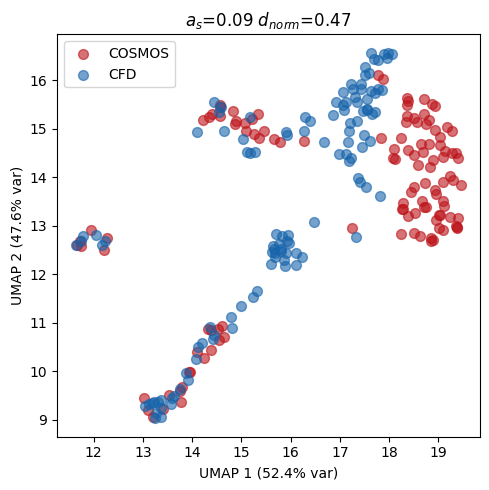

In [6]:
class TrajectoryComparison:
    def __init__(self, cosmos_df, cfd_df):
        self.cosmos_df = cosmos_df
        self.cfd_df = cfd_df
        self.feature_scaler = None
        self.umap_reducer = None
        
    def normalize_units(self):
        """Ensure consistent units between datasets"""
        # First process odor signals
        self.cosmos_df = process_odor_signal(self.cosmos_df)
        self.cfd_df = process_odor_signal(self.cfd_df)
        
        # Scale spatial coordinates to same range
        for df in [self.cosmos_df, self.cfd_df]:
            # Normalize spatial components
            spatial_cols = ['x', 'y', 'vx', 'vy', 'crosswind_dist', 'upwind_dist']
            for col in spatial_cols:
                if col in df.columns:
                    df[col] = df[col] / df[col].abs().max()
            
            # Normalize time steps
            df['time'] = (df['time'] - df['time'].min()) / (df['time'].max() - df['time'].min())
            
            # Normalize angles to [-1, 1]
            angle_cols = ['heading_angle']
            for col in angle_cols:
                if col in df.columns:
                    df[col] = np.unwrap(df[col]) % (2 * np.pi)
                    df[col] = df[col] / np.pi - 1
            
            # Normalize other quantities
            if 'speed' in df.columns:
                df['speed'] = df['speed'] / df['speed'].max()
            if 'acceleration' in df.columns:
                df['acceleration'] = df['acceleration'] / df['acceleration'].abs().max()import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import seaborn as sns

# Save UMAP data
np.save("X_umap.npy", X_umap)
np.save("labels.npy", labels)

def plot_separate_and_combined(X_umap, labels, save_prefix='umap_plot'):
    """Create four different plots of the UMAP data"""
    # Set consistent style parameters
    plt.style.use('seaborn')
    colors = {'COSMOS': '#bc141a', 'CFD': '#1764ab'}
    
    # Calculate variance ratios for axis labels
    var_ratio = np.var(X_umap, axis=0)
    var_ratio = (var_ratio / np.sum(var_ratio)) * 100
    xlabel = f'UMAP 1 ({var_ratio[0]:.1f}% var)'
    ylabel = f'UMAP 2 ({var_ratio[1]:.1f}% var)'
    
    # 1. COSMOS only plot
    fig1, ax1 = plt.subplots(figsize=(8, 6))
    mask_cosmos = labels == 0
    ax1.scatter(X_umap[mask_cosmos, 0], X_umap[mask_cosmos, 1], 
               c=colors['COSMOS'], alpha=0.6, s=50, label='COSMOS')
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.set_title('COSMOS Trajectories')
    ax1.legend()
    fig1.tight_layout()
    fig1.savefig(f'{save_prefix}_cosmos.png', dpi=300, bbox_inches='tight')
    
    # 2. CFD only plot
    fig2, ax2 = plt.subplots(figsize=(8, 6))
    mask_cfd = labels == 1
    ax2.scatter(X_umap[mask_cfd, 0], X_umap[mask_cfd, 1],
                c=colors['CFD'], alpha=0.6, s=50, label='CFD')
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel(ylabel)
    ax2.set_title('CFD Trajectories')
    ax2.legend()
    fig2.tight_layout()
    fig2.savefig(f'{save_prefix}_cfd.png', dpi=300, bbox_inches='tight')
    
    # 3. Combined scatter plot
    fig3, ax3 = plt.subplots(figsize=(8, 6))
    ax3.scatter(X_umap[mask_cosmos, 0], X_umap[mask_cosmos, 1],
                c=colors['COSMOS'], alpha=0.6, s=50, label='COSMOS')
    ax3.scatter(X_umap[mask_cfd, 0], X_umap[mask_cfd, 1],
                c=colors['CFD'], alpha=0.6, s=50, label='CFD')
    ax3.set_xlabel(xlabel)
    ax3.set_ylabel(ylabel)
    ax3.set_title('Combined Trajectories')
    ax3.legend()
    fig3.tight_layout()
    fig3.savefig(f'{save_prefix}_combined.png', dpi=300, bbox_inches='tight')
    
    # 4. Density comparison plot
    fig4, ax4 = plt.subplots(figsize=(8, 6))
    
    # Calculate density for each dataset
    for label, name in enumerate(['COSMOS', 'CFD']):
        mask = labels == label
        data = X_umap[mask]
        
        # Calculate the density
        kernel = gaussian_kde(data.T)
        
        # Create a regular grid to evaluate the density
        x_grid = np.linspace(X_umap[:, 0].min(), X_umap[:, 0].max(), 100)
        y_grid = np.linspace(X_umap[:, 1].min(), X_umap[:, 1].max(), 100)
        X, Y = np.meshgrid(x_grid, y_grid)
        positions = np.vstack([X.ravel(), Y.ravel()])
        
        # Evaluate the density
        Z = np.reshape(kernel(positions).T, X.shape)
        
        # Plot the density with contours
        levels = np.linspace(0, Z.max(), 10)
        ax4.contour(X, Y, Z, levels=levels, colors=colors[name], alpha=0.6)
        ax4.contourf(X, Y, Z, levels=levels, colors=[colors[name]], alpha=0.2)
    
    ax4.set_xlabel(xlabel)
    ax4.set_ylabel(ylabel)
    ax4.set_title('Density Comparison')
    ax4.legend(['COSMOS', 'CFD'])
    fig4.tight_layout()
    fig4.savefig(f'{save_prefix}_density.png', dpi=300, bbox_inches='tight')
    
    plt.close('all')
    print(f"All plots saved with prefix: {save_prefix}")
            if 'angular_velocity' in df.columns:
                df['angular_velocity'] = df['angular_velocity'] / df['angular_velocity'].abs().max()
            if 'path_curvature' in df.columns:
                df['path_curvature'] = df['path_curvature'] / df['path_curvature'].abs().max()
    
    def add_derived_features(self, df):
        """Add carefully normalized derived features"""
        # Simple path efficiency (ratio of displacement to path length)
        df['cumulative_dx'] = df.groupby('trajectory_id')['vx'].cumsum()
        df['cumulative_dy'] = df.groupby('trajectory_id')['vy'].cumsum()
        df['path_length'] = np.sqrt(df['cumulative_dx']**2 + df['cumulative_dy']**2)
        df['path_length'] = df['path_length'] / df['path_length'].max()
        
        # Turn rate (normalized)
        df['turn_rate'] = np.gradient(df['heading_angle'], df['time'])
        df['turn_rate'] = df['turn_rate'] / df['turn_rate'].abs().max()
        
        return df
    
    def extract_features(self):
        """Extract features using minimal tsfresh parameters"""
        # Define basic columns to extract features from
        base_cols = [
            "vx", "vy", "speed", "acceleration",
            "heading_angle", "angular_velocity",
            "crosswind_dist", "upwind_dist",
            "path_curvature", "turn_rate",
            "path_length", "odor"
        ]
        
        # Use only columns that exist in both datasets
        available_cols = []
        for col in base_cols:
            if col in self.cosmos_df.columns and col in self.cfd_df.columns:
                available_cols.append(col)
        
        # Use minimal feature set from tsfresh
        settings = MinimalFCParameters()
        
        # Extract features for both datasets
        cosmos_features = extract_features(
            self.cosmos_df[['trajectory_id', 'time'] + available_cols],
            column_id='trajectory_id',
            column_sort='time',
            default_fc_parameters=settings
        )
        
        cfd_features = extract_features(
            self.cfd_df[['trajectory_id', 'time'] + available_cols],
            column_id='trajectory_id',
            column_sort='time',
            default_fc_parameters=settings
        )
        
        # Ensure both feature sets have the same columns
        common_cols = cosmos_features.columns.intersection(cfd_features.columns)
        cosmos_features = cosmos_features[common_cols]
        cfd_features = cfd_features[common_cols]
        
        # Balance datasets if needed
        min_size = min(len(cosmos_features), len(cfd_features))
        if len(cosmos_features) > min_size:
            cosmos_features = cosmos_features.sample(n=min_size, random_state=42)
        if len(cfd_features) > min_size:
            cfd_features = cfd_features.sample(n=min_size, random_state=42)
        
        return cosmos_features, cfd_features
    
    def fit_transform(self, n_neighbors=15, min_dist=0.1, metric='euclidean'):
        """Fit and transform data with careful preprocessing"""
        # Normalize units
        self.normalize_units()
        
        # Add derived features
        self.cosmos_df = self.add_derived_features(self.cosmos_df)
        self.cfd_df = self.add_derived_features(self.cfd_df)
        
        # Extract features
        cosmos_features, cfd_features = self.extract_features()
        
        # Combine features
        X = pd.concat([cosmos_features, cfd_features])
        y = np.concatenate([
            np.zeros(len(cosmos_features)),
            np.ones(len(cfd_features))
        ])
        
        # Scale features
        self.feature_scaler = RobustScaler()
        X_scaled = self.feature_scaler.fit_transform(X)
        
        # Fit UMAP
        self.umap_reducer = UMAP(
            n_neighbors=n_neighbors,
            min_dist=min_dist,
            metric=metric,
            random_state=42
        )
        X_umap = self.umap_reducer.fit_transform(X_scaled)
        
        return X_umap, y
    
    def plot_comparison(self, X_umap, labels, silhouette, norm_dist):
        """Plot comparison with enhanced visualization and axis labels."""
        f, ax = plt.subplots(figsize=(5, 5))
        
        # Plot points
        for i, label in enumerate(['COSMOS', 'CFD']):
            mask = labels == i
            ax.scatter(
                X_umap[mask, 0],
                X_umap[mask, 1],
                label=label,
                alpha=0.6,
                s=50,
                c=['#bc141a', '#1764ab'][i]
            )
        
        # Calculate variance ratios directly from UMAP coordinates
        var_ratio = np.var(X_umap, axis=0)
        var_ratio = (var_ratio / np.sum(var_ratio)) * 100
        
        # Add labels with variance percentages
        ax.set_xlabel(f'UMAP 1 ({var_ratio[0]:.1f}% var)')
        ax.set_ylabel(f'UMAP 2 ({var_ratio[1]:.1f}% var)')
        
        ax.set_title(f'$a_s$={silhouette:.2f} $d_{{norm}}$={norm_dist:.2f}')
        ax.legend()
        f.tight_layout()
        
        return f

if __name__ == "__main__":
    # Load your data
    path = "/home/gorilla/An/data/simulator/plot/tracking_figure/feb4/"
    osdf_combined = load_and_combine(str(path)+"os*.h5")
    cfd_df_combined = load_and_combine_cfd(str(path)+"cfd*.h5")
    
    # Create comparison object
    comparator = TrajectoryComparison(osdf_combined, cfd_df_combined)
    X_umap, labels = comparator.fit_transform(
        n_neighbors=50,  # Try different values: 15, 30, 50
        min_dist=0.1,    # Try different values: 0.0, 0.1, 0.5
        metric='euclidean'  # Try: 'euclidean', 'cosine', 'correlation'
    )
    
    # Calculate metrics and plot
    silhouette, norm_dist = calculate_metrics(X_umap, labels)
    comparator.plot_comparison(X_umap, labels, silhouette, norm_dist)
    
    # Print metrics
    print("\nCluster Quality Metrics:")
    print(f"Silhouette Score: {silhouette:.3f}")
    print(f"Normalized Centroid Distance: {norm_dist:.3f}")

Before Normalization

Extracting minimal features...


Feature Extraction: 100%|██████████| 79/79 [00:00<00:00, 135.87it/s]
/home/gorilla/An/arunavanag/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Cleaning features...
Scaling features...
Applying UMAP...

Number of features extracted: 100

Cluster Quality Metrics:
Silhouette Score: 0.250
Normalized Centroid Distance: 0.884


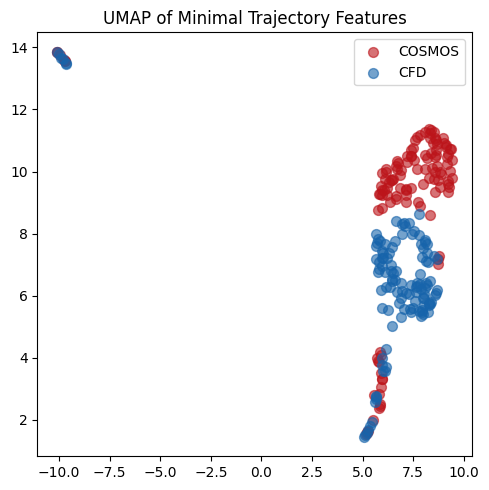

In [ ]:
def compare_trajectories(osdf, cfd_df):
    """Compare trajectories using minimal tsfresh features."""
    # Add time column if not present
    for df in [osdf, cfd_df]:
        if 'time' not in df.columns:
            df['time'] = np.arange(len(df))
    
    # Feature columns for analysis
    feature_cols = [
        "vx", "vy", "speed", "acceleration",
        "heading_angle", "angular_velocity",
        "crosswind_dist", "upwind_dist",
        "dist_to_target",
        "path_curvature"
    ]
    existing_features = [col for col in feature_cols if col in osdf.columns]
    
    # Get minimal feature settings
    settings = MinimalFCParameters()
    
    # Extract features using minimal set
    print("Extracting minimal features...")
    os_features = extract_features(
        osdf[['trajectory_id', 'time'] + existing_features],
        column_id='trajectory_id',
        column_sort='time',
        default_fc_parameters=settings
    )
    
    cfd_features = extract_features(
        cfd_df[['trajectory_id', 'time'] + existing_features],
        column_id='trajectory_id',
        column_sort='time',
        default_fc_parameters=settings
    )
    
    # Clean features
    print("Cleaning features...")
    for features in [os_features, cfd_features]:
        features.replace([np.inf, -np.inf], np.nan, inplace=True)
        features.dropna(axis=1, inplace=True)
    
    # Keep only common columns
    common_cols = os_features.columns.intersection(cfd_features.columns)
    os_features = os_features[common_cols]
    cfd_features = cfd_features[common_cols]
    
    # Add labels and combine
    os_features['source'] = 'COSMOS'
    cfd_features['source'] = 'CFD'
    combined_df = pd.concat([os_features, cfd_features])
    
    # Prepare for UMAP
    X = combined_df.drop('source', axis=1).values
    labels = combined_df['source'].values
    
    # Scale features
    print("Scaling features...")
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply UMAP
    print("Applying UMAP...")
    reducer = UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    X_umap = reducer.fit_transform(X_scaled)
    
    # Visualization
    plt.figure(figsize=(5, 5))
    color_map = {"COSMOS": "#bc141a", "CFD": "#1764ab"}
    
    for src_label in ["COSMOS", "CFD"]:
        mask = (labels == src_label)
        plt.scatter(
            X_umap[mask, 0],
            X_umap[mask, 1],
            label=src_label,
            alpha=0.6,
            c=color_map[src_label],
            s=50
        )
    
    plt.title("UMAP of Minimal Trajectory Features")
    plt.legend()
    plt.tight_layout()
    
    print(f"\nNumber of features extracted: {X.shape[1]}")
    
    return combined_df, X_umap, labels

if __name__ == "__main__":
    path = "/home/gorilla/An/data/simulator/plot/tracking_figure/feb4/"
    osdf_combined = load_and_combine(str(path)+"os*.h5")
    cfd_df_combined = load_and_combine_cfd(str(path)+"cfd*.h5")
    
    # Main comparison
    combined_df, X_umap, labels = compare_trajectories(
        osdf_combined, 
        cfd_df_combined
    )
    
    # Calculate metrics separately
    silhouette, norm_dist = calculate_metrics(X_umap, labels)
    print("\nCluster Quality Metrics:")
    print(f"Silhouette Score: {silhouette:.3f}")
    print(f"Normalized Centroid Distance: {norm_dist:.3f}")
    
